In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from dateutil.relativedelta import relativedelta
import warnings
import os
import glob

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot


warnings.filterwarnings('ignore')
%matplotlib inline

## EDA
- ### Payment Type
- ### Order
- ### Product & Category
- ### Review score & Delivery time
- ### Geolocation

*******************************************************************************************************************************************************************

### Load data

In [3]:
path = './datasets/'
filenames = glob.glob(path + "*.csv")
file_list = []
for file in sorted(filenames):
    file_list.append(pd.read_csv(file))

In [4]:
customers = file_list[0]
geolocation = file_list[1]
items = file_list[2]
payments = file_list[3]
reviews = file_list[4]
orders = file_list[5]
products = file_list[6]
sellers = file_list[7]
categories = file_list[8]

### Payment type

In [100]:
# null check
payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [101]:
# payment types
payments.payment_type.value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [102]:
# payment installments
installments = payments[payments.payment_type == 'credit_card']

Text(0.5, 1.0, 'Payment installments in credit card')

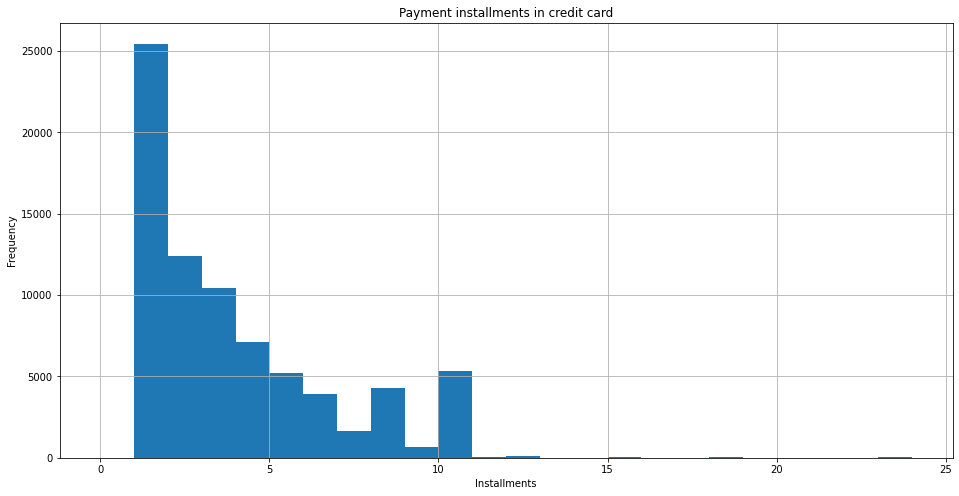

In [103]:
fig, ax = plt.subplots(figsize = (16,8))
installments.hist(column='payment_installments', bins = installments.payment_installments.nunique(), ax=ax)
plt.xlabel("Installments")
plt.ylabel("Frequency")
plt.title("Payment installments in credit card")

<AxesSubplot:xlabel='payment_type'>

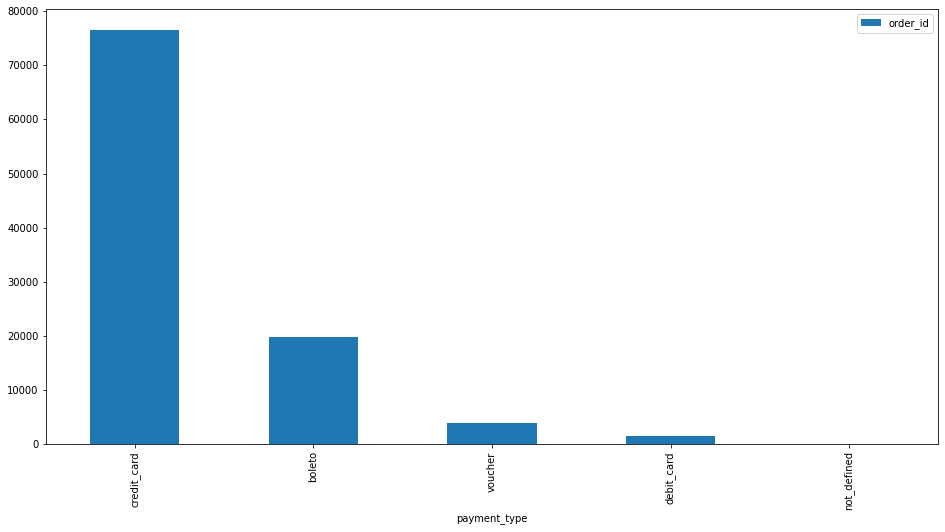

In [104]:
payment_types = payments.groupby('payment_type')[['order_id']].nunique()
payment_types.sort_values('order_id', ascending=False, inplace=True)
payment_types.plot(kind='bar', figsize = (16,8))

In [105]:
# payment value
def detect_outliers(df = payments, col = 'payment_value'):
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3-q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return df[(df[col] <= upper_bound) & (df[col] >= lower_bound)]

# remove 'not_defined' payment_type class
df_within_outliers = detect_outliers(payments[payments.payment_type != 'not_defined'])

Let's filter out outliers in payment values

Text(0.5, 1.0, 'Distribution of payment value by each payment method')

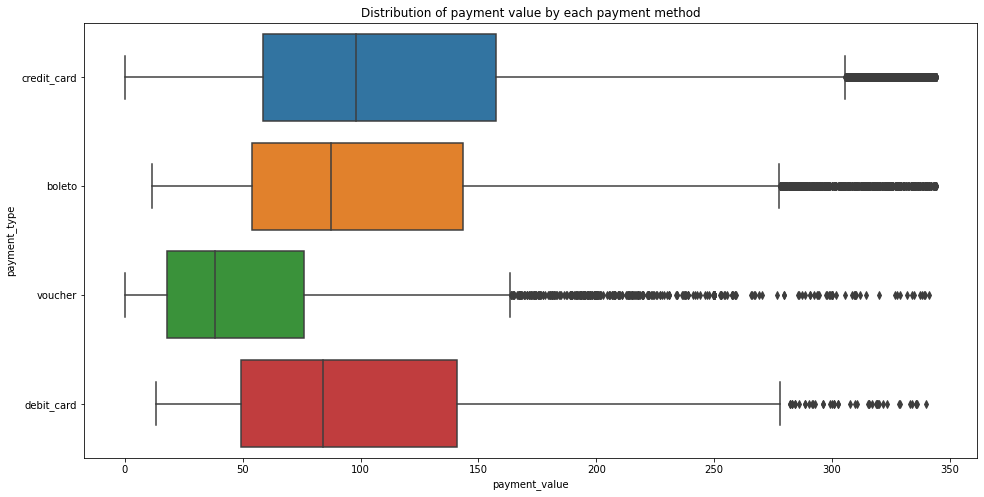

In [106]:
# distributions of payment value in each payment type
fig = plt.figure(figsize=(16,8))
sns.boxplot(df_within_outliers, x='payment_value', y='payment_type')
plt.title("Distribution of payment value by each payment method")

### Order

In [107]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [108]:
tmp_orders = orders.copy()
tmp_orders = tmp_orders[['order_id', 'order_purchase_timestamp', 'order_status','order_delivered_customer_date', 'order_estimated_delivery_date']]

In [109]:
# %Y-%m-%d format
order_purchase_timestamp = pd.to_datetime(tmp_orders.order_purchase_timestamp)
tmp_orders.order_delivered_customer_date = pd.to_datetime(tmp_orders.order_delivered_customer_date)
tmp_orders.order_estimated_delivery_date = pd.to_datetime(tmp_orders.order_estimated_delivery_date)
tmp_orders.order_purchase_timestamp = pd.to_datetime(tmp_orders.order_purchase_timestamp)

- Order Status

In [110]:
tmp_orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [111]:
# remove both created and approved
order_status = tmp_orders[(tmp_orders.order_status != 'created') & (tmp_orders.order_status != 'approved')]
order_status = order_status.groupby('order_status')['order_id'].nunique()

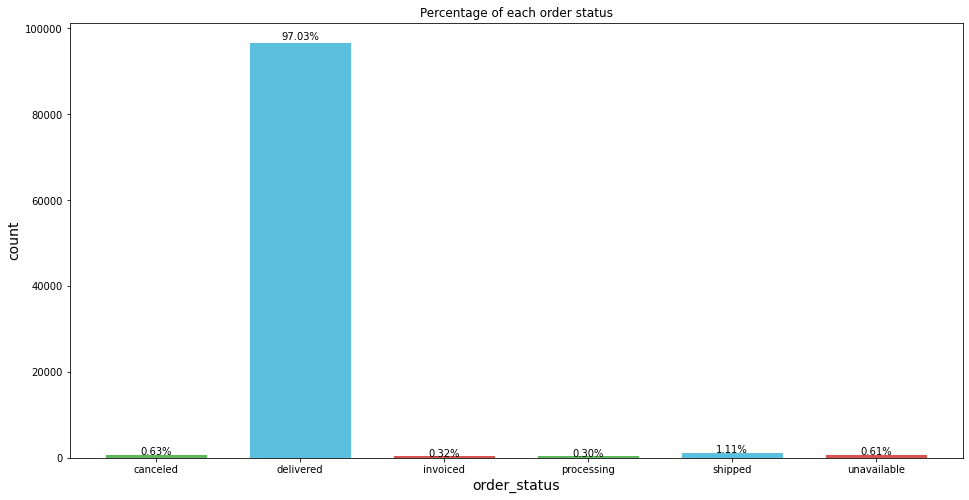

In [112]:
colors_list = ['#5cb85c','#5bc0de','#d9534f']

ax = order_status.plot(kind='bar',figsize=(16,8),width = 0.7,color = colors_list)
plt.xlabel("order_status", fontsize = 14) 
plt.ylabel('count', fontsize=14)
plt.xticks(rotation=0)
plt.title("Percentage of each order status")

for p in ax.patches:
    width = p.get_width()
    height = p.get_height() / order_status.values.sum()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*order_status.values.sum()*1.01), ha='center')

- Orders in each month

<AxesSubplot:xlabel='order_purchase_timestamp'>

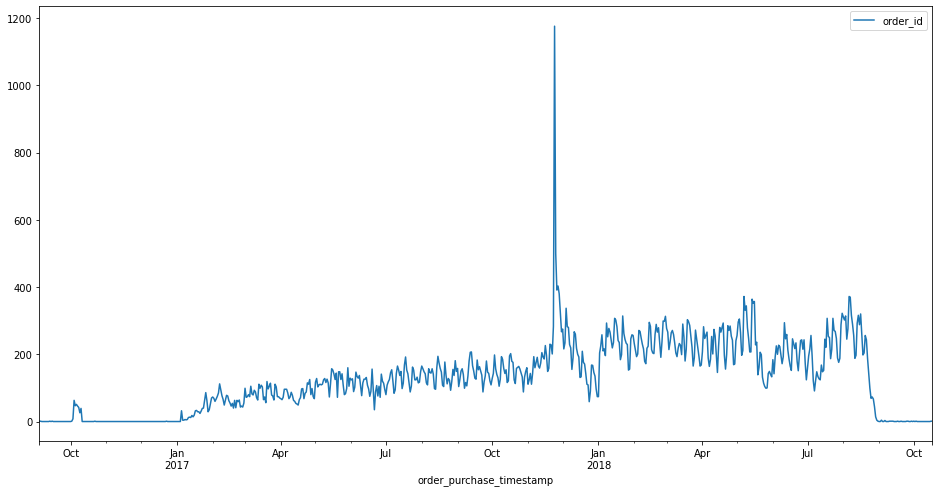

In [113]:
df_cnt = tmp_orders.set_index("order_purchase_timestamp").groupby(pd.Grouper(freq='D')).count()
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
df_cnt.plot(y = "order_id", use_index=True, ax=ax)

There were so many orders in Dec 2017 and it's probably because of the Christmas and New Year's Eve

- Orders by weekday

In [114]:
order_day = tmp_orders.copy()
order_day.order_purchase_timestamp = order_day.order_purchase_timestamp.dt.day_name()
order_day = order_day.groupby('order_purchase_timestamp')['order_id'].count()
# sort (Mon ~ Sun =)
order_day = order_day.reindex(index = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

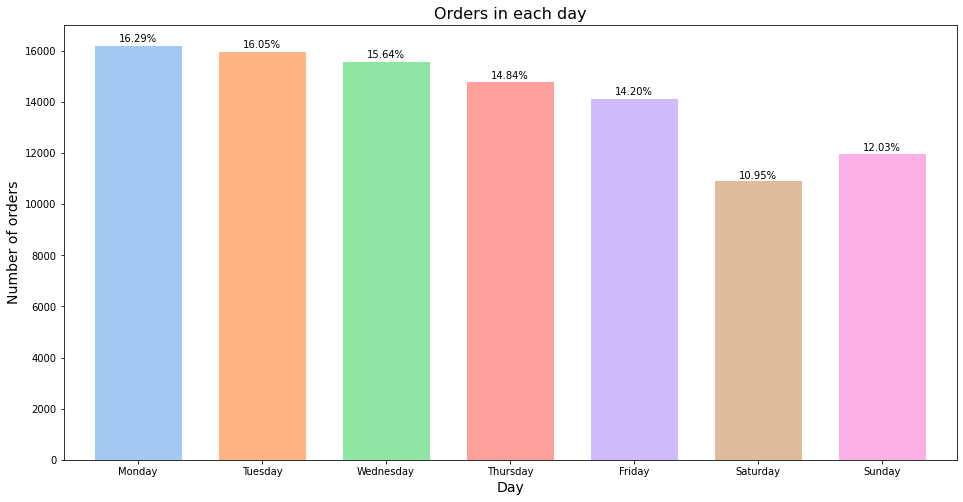

In [115]:
colors = sns.color_palette('pastel',len(order_day))

ax = order_day.plot(kind='bar',figsize=(16,8),width = 0.7, color = colors)
plt.xlabel("Day", fontsize = 14) 
plt.ylabel('Number of orders', fontsize=14)
plt.xticks(rotation=0)
plt.title("Orders in each day", fontsize=16)

for p in ax.patches:
    width = p.get_width()
    height = p.get_height() / order_day.values.sum()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*order_day.values.sum().sum()*1.01), ha='center')

### Product & Category

In [116]:
df_product = products.copy()
df_items = items.copy()

category = dict(zip(df_product.product_id, df_product.product_category_name))
category_english = dict(zip(categories.product_category_name, categories.product_category_name_english))

df_items['category'] = df_items.product_id.map(category)
df_items['category_english'] = df_items.category.map(category_english)

df_items.fillna('Unknown', inplace=True)
df_items = df_items[['order_id', 'product_id', 'category_english', 'price']]
df_items.head()

,order_id,product_id,category_english,price
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,58.90
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,pet_shop,239.90
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,199.00
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,perfumery,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,garden_tools,199.90


- Top 5 products (# of orders)

In [117]:
top5_products = df_items.groupby('product_id')[['order_id']].count()
top5_products.sort_values(by='order_id', ascending=False, inplace=True)
top5_products = top5_products.head(5)
top5_products

,order_id
product_id,
aca2eb7d00ea1a7b8ebd4e68314663af,527
99a4788cb24856965c36a24e339b6058,488
422879e10f46682990de24d770e7f83d,484
389d119b48cf3043d311335e499d9c6b,392
368c6c730842d78016ad823897a372db,388


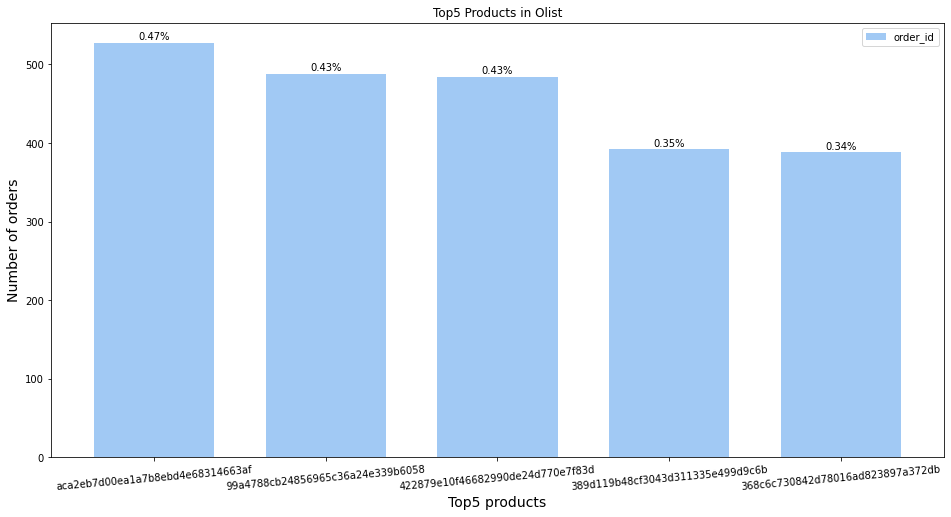

In [118]:
colors = sns.color_palette('pastel',len(top5_products))
ax = top5_products.plot(kind='bar',figsize=(16,8),width = 0.7, color = colors)
plt.xlabel("Top5 products", fontsize = 14) 
plt.ylabel('Number of orders', fontsize=14)
plt.xticks(rotation=5)
plt.title("Top5 Products in Olist")

for p in ax.patches:
    width = p.get_width()
    height = p.get_height() / items.shape[0]
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*items.shape[0]*1.01), ha='center')

- Top 5 categories (# of orders)

In [119]:
top5_categories = df_items.groupby("category_english")[['order_id']].count()
top5_categories.sort_values(by='order_id', ascending=False, inplace=True)
top5_categories.head(5)

,order_id
category_english,
bed_bath_table,11115
health_beauty,9670
sports_leisure,8641
furniture_decor,8334
computers_accessories,7827


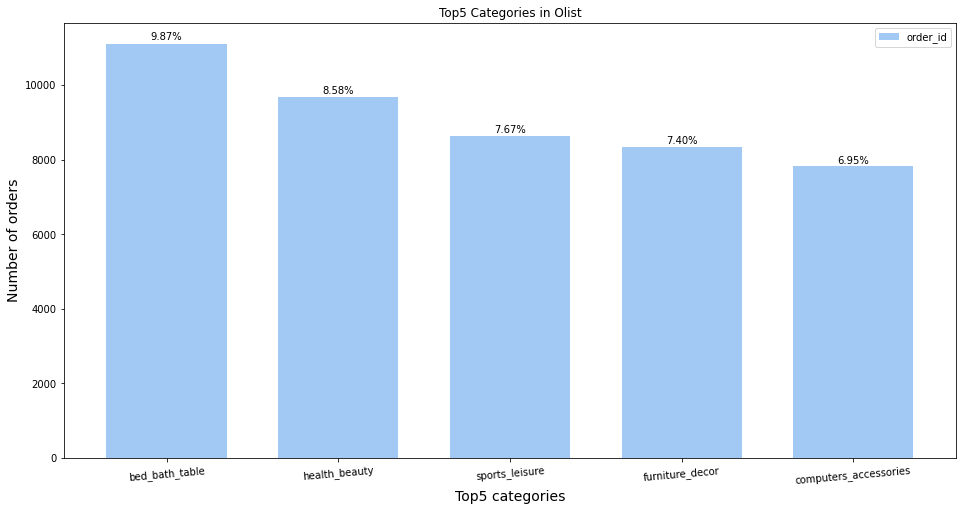

In [120]:
colors = sns.color_palette('pastel',len(top5_categories))
ax = top5_categories.head(5).plot(kind='bar',figsize=(16,8),width = 0.7, color = colors)
plt.xlabel("Top5 categories", fontsize = 14) 
plt.ylabel('Number of orders', fontsize=14)
plt.xticks(rotation=5)
plt.title("Top5 Categories in Olist")

for p in ax.patches:
    width = p.get_width()
    height = p.get_height() / items.shape[0]
    x, y = p.get_xy() 
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*items.shape[0]*1.01), ha='center')

### Review score & Delivery time

In [121]:
delivery = orders.copy()
delivery = delivery[delivery.order_status == 'delivered']
delivery['order_purchase_timestamp'] = pd.to_datetime(delivery['order_purchase_timestamp'])
delivery['order_delivered_customer_date'] = pd.to_datetime(delivery['order_delivered_customer_date'])

In [122]:
delivery.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [123]:
# order_estimated_delivery_date -> 8 NAs in order_delivered_customer_date
null_idx = delivery[delivery.order_delivered_customer_date.isna() == True].index
delivery.loc[null_idx, 'order_delivered_customer_date'] = delivery.loc[null_idx, 'order_estimated_delivery_date']
delivery.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     0
order_estimated_delivery_date     0
dtype: int64

- Delivery time in days vs Review score

In [124]:
# difference in days
delivery['delivery_time'] = delivery['order_delivered_customer_date'] - delivery['order_purchase_timestamp']
delivery.delivery_time = delivery.delivery_time / np.timedelta64(1, 'D')

# review score mapping
order_reviews = dict(zip(reviews.order_id, reviews.review_score))
delivery['score'] = delivery.order_id.map(order_reviews)

# choose columns & dropna
delivery = delivery[['order_id', 'order_purchase_timestamp', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'delivery_time', 'score']]
delivery.dropna(inplace=True)
delivery.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,delivery_time,score
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18 00:00:00,8.436574,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13 00:00:00,13.782037,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04 00:00:00,9.394213,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15 00:00:00,13.208750,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26 00:00:00,2.873877,5.0


Text(0, 0.5, 'Review Score')

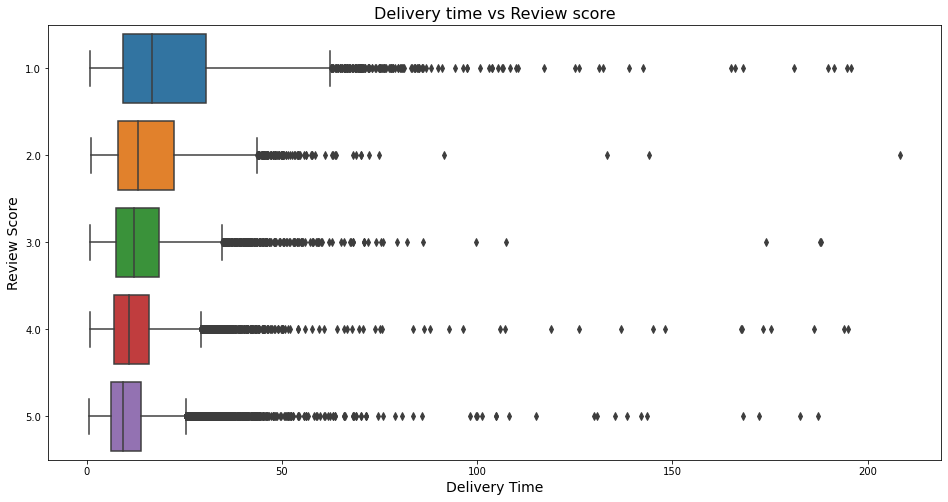

In [125]:
tmp_delivery = delivery.copy()
tmp_delivery.score = tmp_delivery.score.astype(str)
tmp_delivery.sort_values(by='score', ascending=True, inplace=True)
fig = plt.figure(figsize=(16,8))
sns.boxplot(tmp_delivery, x='delivery_time', y='score') 
plt.title("Delivery time vs Review score", fontsize=16) 
plt.xlabel('Delivery Time', fontsize=14)
plt.ylabel("Review Score", fontsize=14)

Observation
- It appears that the review score decreases as delivery time increases, indicating a strong negative relationship between the two.

### Geolocation

Let's see the cities in Brazil on a map

In [ ]:
geo = [go.Scattermapbox(lon = geolocation['geolocation_lng'],
                        lat = geolocation['geolocation_lat'],
                        text = geolocation['geolocation_city'],
                        marker = dict(size = 3,
                                      color = 'tomato',))]

layout = dict(title = 'Brazil City',
              mapbox = dict(accesstoken = 'pk.eyJ1IjoiaG9vbmtlbmc5MyIsImEiOiJjam43cGhpNng2ZmpxM3JxY3Z4ODl2NWo3In0.SGRvJlToMtgRxw9ZWzPFrA',
                            center= dict(lat=-22,lon=-43),
                            bearing=10,
                            pitch=0,
                            zoom=2,))

fig = dict(data=geo, layout=layout)
iplot(fig, validate=False)
count_city = geolocation['geolocation_city'].value_counts()


Top 10 cities based on the number of orders

There are 4119 unique cities in the database. The TOP 10 cities are:
customer_city
sao paulo                15540
rio de janeiro            6882
belo horizonte            2773
brasilia                  2131
curitiba                  1521
campinas                  1444
porto alegre              1379
salvador                  1245
guarulhos                 1189
sao bernardo do campo      938
Name: customer_id, dtype: int64

TOP 10 cities covers 35.2 percent of all the orders.


<AxesSubplot:xlabel='customer_city'>

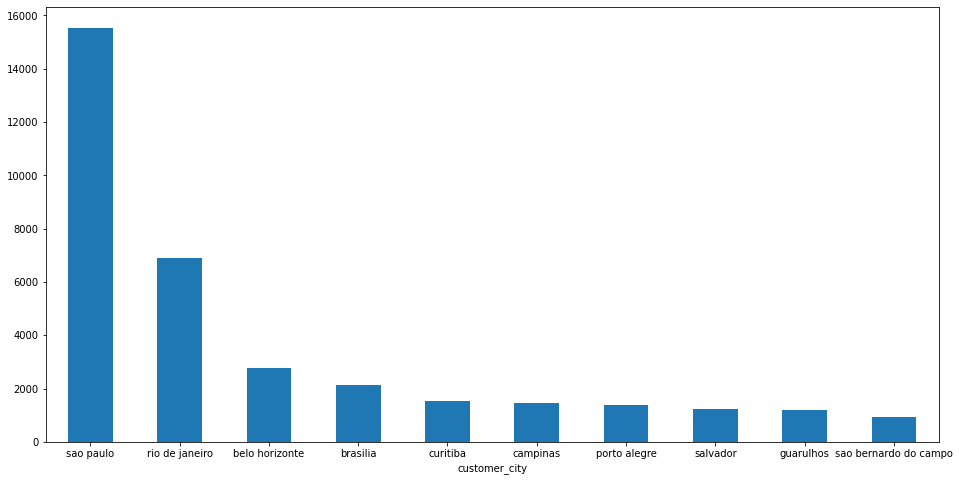

In [126]:
cities = customers["customer_city"].nunique()
c1 = customers.groupby('customer_city')['customer_id'].nunique().sort_values(ascending=False)
print("There are",cities,"unique cities in the database. The TOP 10 cities are:")
c2 = c1.head(10)
print(c2)
plt.figure(figsize=(16,8))
c2.plot(kind="bar",rot=0)

Observation
- Top 10 cities covers 35.2 percent of all the orders.

Then, let's see the top10 States in Brazil based on the number of orders

In [12]:
geo_state = geolocation.groupby('geolocation_state')['geolocation_lat','geolocation_lng'].mean().reset_index()
geo_city = geolocation.groupby('geolocation_city')['geolocation_lat','geolocation_lng'].mean().reset_index()


geo = [go.Scattermapbox(lon = geo_state['geolocation_lng'],
                        lat = geo_state['geolocation_lat'],
                        text = geo_state['geolocation_state'],
                        marker = dict(size = 18,
                                      color = 'tomato',))]

layout = dict(title = 'Brazil State',
              mapbox = dict(accesstoken = 'pk.eyJ1IjoiaG9vbmtlbmc5MyIsImEiOiJjam43cGhpNng2ZmpxM3JxY3Z4ODl2NWo3In0.SGRvJlToMtgRxw9ZWzPFrA',
                            center= dict(lat=-22,lon=-43),
                            bearing=10,
                            pitch=0,
                            zoom=2,))

fig = dict(data=geo, layout=layout)
iplot(fig, validate=False)


Observations
- 1
- 2